# About
- The Immigration and Nationality Act (INA) of the US permits foreign workers to come to the United States to work on either a temporary or permanent basis. The act also protects US workers against adverse impacts on working place and maintain requirements when they hire foreign workers to fill workforce shortages. The immigration programs are administered by the Office of Foreign Labor Certification (OFLC).

## 1) Problem statement.
- OFLC gives job certification applications for employers seeking to bring foreign workers into the United States and grants certifications.
- As In last year the count of employees were huge so OFLC needs Machine learning models to shortlist visa applicants based on their previous data.

##### In this project we are going to use the data given to build a Classification model:

- This model is to check if Visa get approved or not based on the given dataset.
- This can be used to Recommend a suitable profile for the applicants for whom the visa should be certified or denied based on the certain criteria which influences the decision.

In [41]:
import os
from datetime import datetime

import matplotlib.pyplot as plt
import pandas as pd

from VisaPrediction import constants
from dotenv import load_dotenv
import sys

load_dotenv()

True

In [4]:
# Define a fallback path if __file__ is not defined
main_file = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, main_file)
print(main_file)

/Users/mohitverma/Documents/Machine Learning Task/US Visa Prediction 


In [5]:
from pymongo import MongoClient

URI = os.getenv("MONGODB_URI")
client = MongoClient(URI)
client

MongoClient(host=['ac-vrsbqc0-shard-00-00.02i1l78.mongodb.net:27017', 'ac-vrsbqc0-shard-00-01.02i1l78.mongodb.net:27017', 'ac-vrsbqc0-shard-00-02.02i1l78.mongodb.net:27017'], document_class=dict, tz_aware=False, connect=True, appname='Cluster0', authsource='admin', replicaset='atlas-77us37-shard-0', tls=True)

In [6]:
MongoDB_db_name = client[constants.DATABASE_NAME]
MongoDB_collection_name = MongoDB_db_name[constants.COLLECTION_NAME]

In [10]:
data = pd.read_csv(os.getenv('DATASET_GIT_URL'))
data.head(5)

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified


In [11]:
data.shape

(25480, 12)

In [13]:
data.isna().sum()

case_id                  0
continent                0
education_of_employee    0
has_job_experience       0
requires_job_training    0
no_of_employees          0
yr_of_estab              0
region_of_employment     0
prevailing_wage          0
unit_of_wage             0
full_time_position       0
case_status              0
dtype: int64

In [17]:
data[data.columns].duplicated().sum()

0

In [26]:
cat_cols = data.select_dtypes(include=['O'])
num_cols =  data.select_dtypes(exclude=['O'])
print('Total number of categorical columns:', len(cat_cols.columns))
print('Total number of categorical columns:', len(num_cols.columns))

Total number of categorical columns: 9
Total number of categorical columns: 3


In [28]:
num_cols.head(4)

,no_of_employees,yr_of_estab,prevailing_wage
0,14513,2007,592.2029
1,2412,2002,83425.6500
2,44444,2008,122996.8600
3,98,1897,83434.0300


In [29]:
cat_cols.head(4)

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,region_of_employment,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,West,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,Northeast,Year,Y,Certified
2,EZYV03,Asia,Bachelor's,N,Y,West,Year,Y,Denied
3,EZYV04,Asia,Bachelor's,N,N,West,Year,Y,Denied


## UNDERSTANDING DATA

In [36]:
for cols in cat_cols.columns.tolist():
    print(f'Total number of class in {cols} : {len(data[cols].unique().tolist())}')

Total number of class in case_id : 25480
Total number of class in continent : 6
Total number of class in education_of_employee : 4
Total number of class in has_job_experience : 2
Total number of class in requires_job_training : 2
Total number of class in region_of_employment : 5
Total number of class in unit_of_wage : 4
Total number of class in full_time_position : 2
Total number of class in case_status : 2


In [33]:
cat_cols.columns

Index(['case_id', 'continent', 'education_of_employee', 'has_job_experience',
       'requires_job_training', 'region_of_employment', 'unit_of_wage',
       'full_time_position', 'case_status'],
      dtype='object')

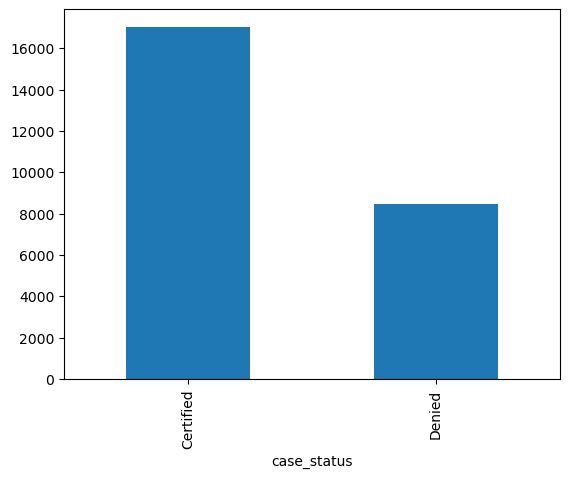

In [42]:
# checking for data target class 

data.case_status.value_counts().plot(kind='bar')
plt.show()

- Case status has imbalanced Class, where the Certified has more numbers rather than Denied status.

In [47]:
# proportion count of each class columns 

for cols in cat_cols.columns.tolist():
    print(data[cols].value_counts(normalize=True) * 100)
    print('---------------------------')

case_id
EZYV01       0.003925
EZYV16995    0.003925
EZYV16993    0.003925
EZYV16992    0.003925
EZYV16991    0.003925
               ...   
EZYV8492     0.003925
EZYV8491     0.003925
EZYV8490     0.003925
EZYV8489     0.003925
EZYV25480    0.003925
Name: proportion, Length: 25480, dtype: float64
---------------------------
continent
Asia             66.173469
Europe           14.646782
North America    12.919937
South America     3.343799
Africa            2.162480
Oceania           0.753532
Name: proportion, dtype: float64
---------------------------
education_of_employee
Bachelor's     40.164835
Master's       37.810047
High School    13.422292
Doctorate       8.602826
Name: proportion, dtype: float64
---------------------------
has_job_experience
Y    58.092622
N    41.907378
Name: proportion, dtype: float64
---------------------------
requires_job_training
N    88.402669
Y    11.597331
Name: proportion, dtype: float64
---------------------------
region_of_employment
Northeast    2

#### Understanding
1. __Case-ID__ : This columns having all the unique-ID which is not usefull.
2. __Continent__ : In this, Asia class overrated then, any other classes having 66% people from ASIA & rest of them are from other continent.
3. __Education_of_employee__ : Bachelor's and Master's education has high number's to get Visa approval rest education are less, so we make it one.
4. __Requires_job_training__ : The people needs Job training which is less and more people are not required any job training.